In [193]:
import matplotlib.pyplot as plt
import math


In [198]:
N = 50
it = 10000
x0 = -1
x1 = 1
dx = (x1 - x0) / N
x = [x0 + i * dx for i in range(N + 1)]

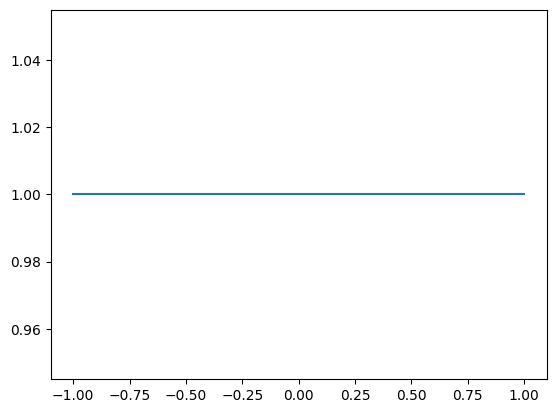

In [199]:
u0 = u1 = 1
u = [u0 + dx * i * (u1 - u0) / (x1 - x0) for i in range(N + 1)]
u_sol = [math.exp((x[i] ** 4 - 1) / 4) for i in range(N + 1)]
u_old = u[:]
plt.plot(x, u)

In [200]:
relaxation = 1
match relaxation:
    case 0:
        for iter in range(it):
            for i in range(1, N):
                u[i] = (u[i + 1] + u[i - 1]) / (2 + dx * dx * (x[i] ** 6 + 3 * x[i] ** 2))
    case 1:
        for iter in range(it):
            _u = u[:]
            for i in range(1, N):
                _u[i] = (u[i + 1] + u[i - 1]) / (2 + dx * dx * (x[i] ** 6 + 3 * x[i] ** 2))
            u = _u[:]

res = [0] * (N + 1)
for i in range(1, N):
    res[i] = (u[i + 1] + u[i - 1]) / (2 + dx * dx * (x[i] ** 6 + 3 * x[i] ** 2)) - u[i]
                
        

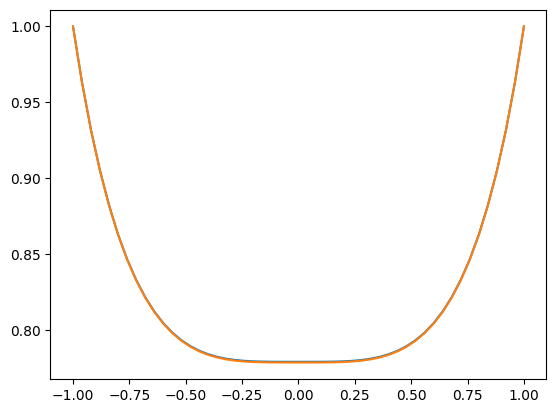

In [201]:
plt.plot(x, u)
plt.plot(x, u_sol)

# plt.ylim(0.94, 1)

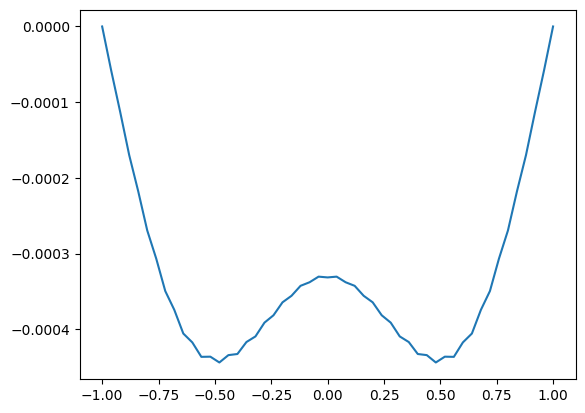

In [83]:
plt.plot(x, res)

In [179]:
class Multigrid:
    def __init__(self, depth, iter, x0, x1, u0, u1, s=None):
        self.depth = depth
        self.N = 2 ** depth
        self.iter = iter
        self.x0 = -1
        self.x1 = 1

        self.num_cells = [(2 << _) for _ in range(depth)]
        self.dx = [(x1 - x0) / (2 << _) for _ in range(depth)]
        self.x = [[x0 + i * self.dx[_] for i in range((2 << _) + 1)] for _ in range(depth)]
        self.u = [[0] * ((2 << _) + 1) for _ in range(depth)]
        self.s = [[0] * ((2 << _) + 1) for _ in range(depth)]
        self.res = [[0] * ((2 << _) + 1) for _ in range(depth)]
        self.u[-1][0] = u0
        self.u[-1][-1] = u1
        if s:
            for i in range(1, self.N):
                self.s[-1][i] = s[i]
        
    def relax(self, depth):
        for _ in range(self.iter):
            self.relax_rb(depth)
    def relax_gs(self, depth):
        for i in range(1, self.num_cells[depth]):
            self.u[depth][i] = (self.u[depth][i + 1] + self.u[depth][i - 1] - self.s[depth][i] * self.dx[depth] * self.dx[depth]) / 2
    def relax_rb(self, depth):
        for i in range(1, self.num_cells[depth], 2):
            self.u[depth][i] = (self.u[depth][i + 1] + self.u[depth][i - 1] - self.s[depth][i] * self.dx[depth] * self.dx[depth]) / 2
        for i in range(2, self.num_cells[depth], 2):
            self.u[depth][i] = (self.u[depth][i + 1] + self.u[depth][i - 1] - self.s[depth][i] * self.dx[depth] * self.dx[depth]) / 2
    def prolongation(self, depth):
        for i in range(self.num_cells[depth]):
            if i & 1:
                self.u[depth][i] += (self.u[depth - 1][i >> 1] + self.u[depth - 1][(i >> 1) + 1]) / 2
            else:
                self.u[depth][i] += self.u[depth - 1][i >> 1]
        
    def restriction(self, depth):
        self.s[depth][0] = self.res[depth + 1][0]
        self.s[depth][-1] = self.res[depth + 1][-1]
        for i in range(1, self.num_cells[depth]):
            self.s[depth][i] = (self.res[depth + 1][2 * i - 1] + 2 * self.res[depth + 1][2 * i] + self.res[depth + 1][2 * i + 1]) / 4
        for i in range(self.num_cells[depth]):
            self.u[depth][i] = 0
    def residual(self, depth):
        for i in range(1, self.num_cells[depth]):
            self.res[depth][i] = self.s[depth][i] - (self.u[depth][i + 1] + self.u[depth][i - 1] - 2 * self.u[depth][i]) / self.dx[depth] / self.dx[depth]
    def norm_residual(self):
        cnt = 0
        for i in range(self.N):
            cnt += self.res[self.depth - 1][i] ** 2
        cnt /= self.N
        return cnt ** .5 * self.dx[-1] * self.dx[-1]
    def multigrid(self, lvs):
        if lvs == 0:
            self.relax(lvs)
            return
        self.relax(lvs)
        self.residual(lvs)
        self.restriction(lvs - 1)
        self.multigrid(lvs - 1)
        self.prolongation(lvs)
        
        self.relax(lvs)
    def solve(self):
        while 1:
            self.multigrid(self.depth - 1)
            x = self.norm_residual()
            print(x)
            if x < 1E-15:
                break

        return self.u[-1][:]



In [183]:
import math

def src_func(x):
    return - math.pi**2 * math.sin(math.pi * x)
x0 = 0
x1 = 1
u0 = 1
u1 = 0
level = 19
N = 1 << level
dx = (x1 - x0) / N
x = [x0 + i * dx for i in range(N + 1)]
source = [src_func(i) for i in x]
mg = Multigrid(level, 1, x0, x1, u0, u1, source)

In [184]:
sol = mg.solve()
# 14484050005.749975
# 62699496.57766948
# 329400.22289557906
# 1839.268967782863
# 10.609886020801934
# 0.06677336944936862
# 0.023485464041662612
# 0.023634663628178235
# 0.023725868352367202
# 0.023672731823596173

0.0004882812500000017
1.226336104934999e-16
1.4039911808597994e-16
1.4361322583900447e-16
1.47586693700983e-16
1.469283265562783e-16
1.466802326825848e-16
1.4650388231678812e-16
1.4702260338289936e-16
1.473653080712611e-16


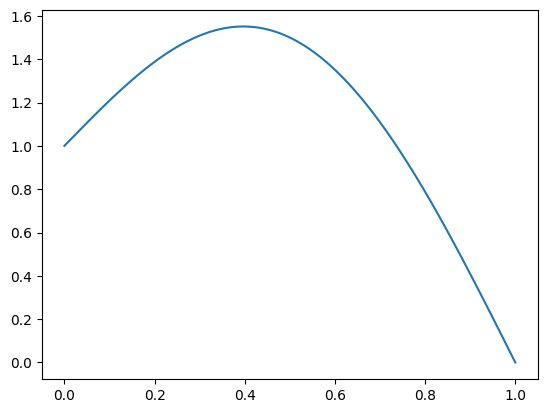

In [185]:
plt.plot(x, sol)

In [ ]:
N = 50
it = 100
x0 = -1
x1 = 1
dx = (x1 - x0) / N
x = [x0 + i * dx for i in range(N + 1)]
u0 = u1 = 1
u = [u0 + dx * i * (u1 - u0) / (x1 - x0) for i in range(N + 1)]
u_sol = [math.exp((x[i] ** 6 - 1) / 4) for i in range(N + 1)]
u_old = u[:]
plt.plot(x, u)

In [189]:
dep = 10
N = 2 ** dep
x0 = -1
x1 = 1
dx = (x1 - x0) / N
x = [x0 + i * dx for i in range(N + 1)]
u0 = u1 = 1
u = [u0 + dx * i * (u1 - u0) / (x1 - x0) for i in range(N + 1)]
g = [i ** 6 + 3 * i ** 2 for i in x]
u_sol = [math.exp((x[i] ** 6 - 1) / 4) for i in range(N + 1)]

In [190]:
def nonlin_iter():
    residual = [0] * (N + 1)
    for i in range(1, N):
        residual[i] = g[i] * u[i] - (u[i + 1] + u[i - 1] - 2 * u[i]) / dx / dx
    mg = Multigrid(dep, 1, x0, x1, 0, 0, residual)
    delta_u = mg.solve()
    for i in range(1, N):
        u[i] += delta_u[i]


In [191]:
nonlin_iter()

8.52505110054245e-06
2.900239526220919e-17
2.911070274706274e-17
3.1712400083581114e-17
3.126430971385647e-17
3.1863706091090984e-17
3.161648954550018e-17
3.1319519895891385e-17
3.2396864576855125e-17
3.269241862696769e-17


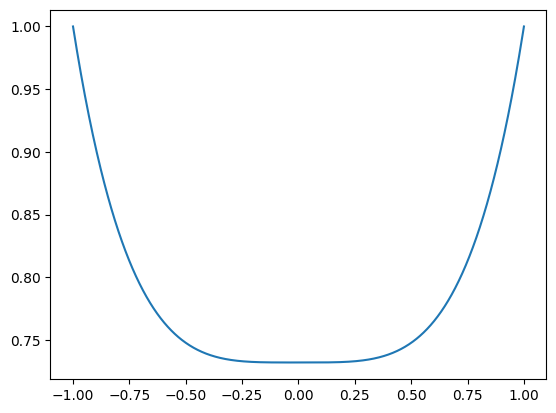

In [192]:
plt.plot(x, u)